# Post Earnings Announcement Drift & Accruals anomaly

This notebook aims to examine if the [Accrual anomaly](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1793364) and [PEAD drift](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1510321) still exists today. 

Because of data availability, the timeframe is only from 1st Jan 2017- 1st Jan 2020. <br>
I've opted to exclude the months of COVID-19 due to extreme volatility in the market and influx of liquidity introduced.<br>
The holding period for each stock will be monthly and the rebalancing is done at the end of each month.

## Thought process

### Part 1 - Figuring out data availability & data visualization
1. What timeframe in which earnings are available?
2. Limit to stocks that have earnings in that timeframe
3. Visualise PEAD effect on stocks

### Part 2 - Calculating accruals
1. Calculate accruals for that timeperiod - meaning know which columns contribute to accruals
2. Calculate accruals as a portion of earnings

### Part 3 - Generating Positions for the time period
1. Create a list of rebalancing dates for the time period
2. Stitch together accruals & estimates, sort accordingly and get the tickers

### Part 4 - Backtesting
1. To optimize speed, prepare a DataFrame with price data readily available

### Part 5 - Plot performance and benchmark against SPY
1. Plot cumulative performance
2. Plot monthly performance

### Importing Packages

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pandas_datareader as wb
import dateutil.relativedelta
from pprint import pprint
plt.style.use('fast')
pd.options.mode.chained_assignment = None
%matplotlib inline

### Part 1 - Figuring out data availability & data visualization

In [45]:
fundamentals = pd.read_csv('US_Financials.csv')
e_hist = pd.read_csv('US_earnings_History.csv')

In [46]:
e_hist['surprisePercent'] = e_hist['epsDifference'] / e_hist['epsEstimate'] * 100 
e_hist.dropna(axis=0,subset=['epsActual','epsEstimate','surprisePercent'],inplace=True)
e_hist[["reportDate", "date"]] = e_hist[["reportDate", "date"]].apply(pd.to_datetime)

Text(0, 0.5, 'Count of Announcements')

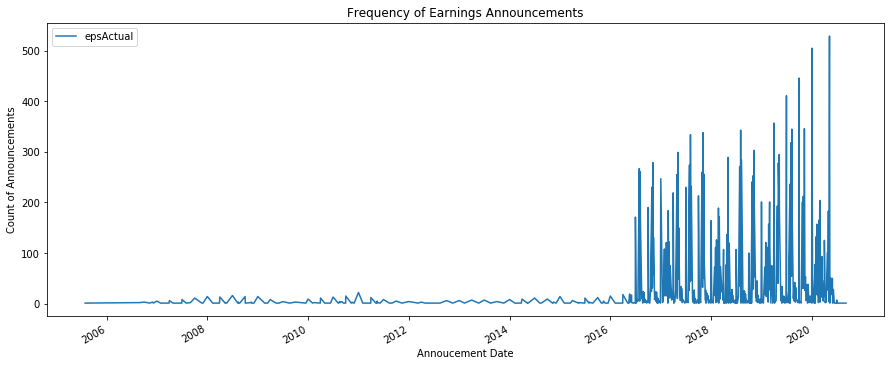

In [47]:
freq_table = e_hist.groupby('reportDate').count()[['epsActual']]
freq_table.plot(figsize=(15,6))
plt.title('Frequency of Earnings Announcements')
plt.xlabel('Annoucement Date')
plt.ylabel('Count of Announcements')

Quick eyeballing tells us that earnings data is not readily available prior to Q3 of 2016. Hence, we'll limit the data to 2017-2020.

In [48]:
end_date = datetime.strptime('2020-01-01', '%Y-%m-%d')
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d')
e_hist = e_hist[(e_hist['reportDate'] >= start_date) & (e_hist['reportDate'] <= end_date)]

Now we want to check if the earnings data is complete, given that between 2017-2020 there should be approx 10-12 records of earnings.

In [49]:
valid_tickers = e_hist.groupby('Ticker').count()['reportDate'].reset_index()
min_records = valid_tickers['reportDate'].min()
max_records = valid_tickers['reportDate'].max()
print('Min No. of records:',min_records)
print('Max No. of records:',max_records)

Min No. of records: 1
Max No. of records: 13


This tells us that for some tickers, there is incomplete data. Here, we could choose to remove these tickers altogether or retain them for the sake of potentially holding them when the data is available. In this instance, to widen the universe for positions, i'll limit it to at least 5 records and above. (5 is just arbitrarily chosen)

In [50]:
tickers = valid_tickers[valid_tickers['reportDate'] >= 5]['Ticker']
e_hist_final = e_hist[e_hist['Ticker'].isin(tickers)]

In [51]:
e_hist_final.head()

,Ticker,reportDate,date,epsActual,epsEstimate,epsDifference,surprisePercent
6,RUTH,2019-11-01,2019-09-30,0.1500,0.10,0.0500,50.000000
7,RUTH,2019-08-02,2019-06-30,0.3100,0.31,0.0000,0.000000
8,RUTH,2019-05-03,2019-03-31,0.4500,0.45,0.0000,0.000000
9,RUTH,2019-02-22,2018-12-31,0.4941,0.49,0.0041,0.836735
10,RUTH,2018-11-02,2018-09-30,0.1186,0.11,0.0086,7.818182


Now to do some visualisations to see if the PEAD exists

In [82]:
## Plotting Function
def plot_hypothesis(ticker,e_hist_final,start_date,end_date):
    ticker = ticker.upper()
    tickers = [ticker]

    df = pd.DataFrame()
    for ticker in tickers:
        df[ticker] = wb.DataReader(ticker,data_source='yahoo',start=start_date,end=end_date)['Adj Close']
        
    idx = pd.date_range(start_date,end_date)
    df = df.reindex(idx, method='ffill')
    df.reset_index(inplace=True)
    df.columns = ['Date','Adjusted_close']
    df.dropna(inplace=True)
    
    stock = e_hist_final[e_hist_final['Ticker']==ticker]

    fig, ax1 = plt.subplots(figsize=(15,6))
    ax2 = ax1.twinx()
    ax1.plot(df['Date'], df['Adjusted_close'], 'black',label='{} Share Price'.format(ticker))
    ax2.plot(stock['reportDate'], stock['surprisePercent'], 'blue',marker='o',linestyle='--',label='EPS Surprise %')

    ax1.set_xlabel('Reported Date')
    ax1.set_ylabel('{} Share Price'.format(ticker),color='black')
    ax2.set_ylabel('EPS',color='black')
    
    #plotting vertical & horizontal lines
    plt.plot(df['Date'],[0 for i in range(len(df['Date']))],'black',linestyle='--',markersize=0.5,label='Zero line')
    for point in stock['reportDate']:
        plt.axvline(x=point,color='grey',alpha=0.5,linestyle=':')
    plt.title('{} Post Earnings Drift Hypothesis'.format(ticker),color='black')
    ax2.legend(loc='upper left')
    ax1.legend(loc='lower left')
    plt.show()

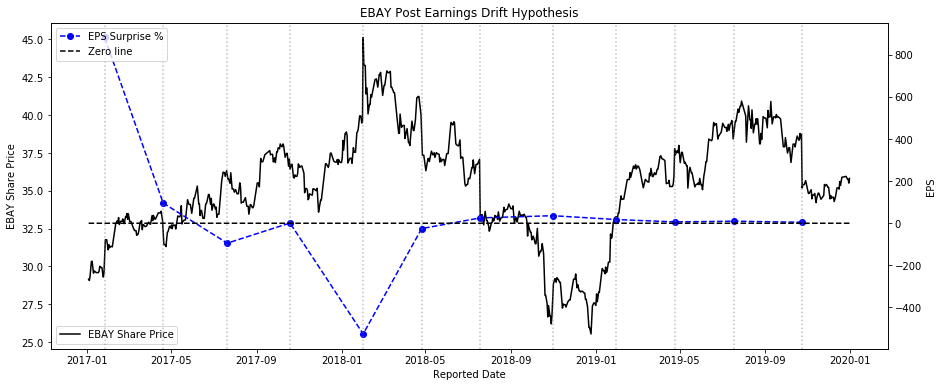

In [84]:
plot_hypothesis('EBAY',e_hist_final,start_date,end_date)

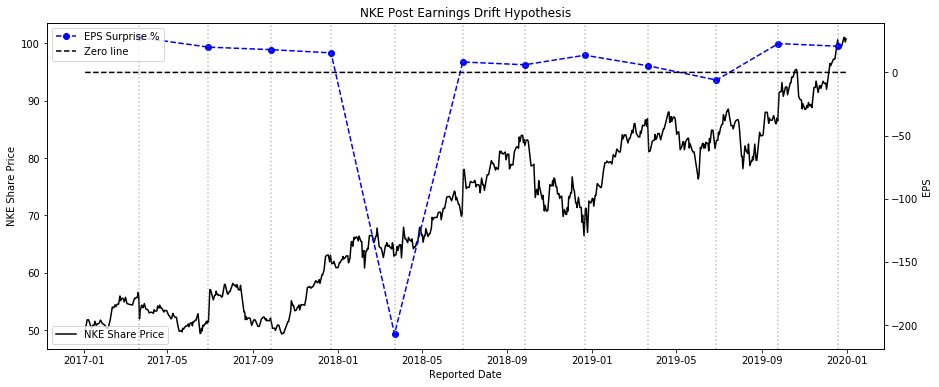

In [87]:
plot_hypothesis('NKE',e_hist_final,start_date,end_date)
#Some missing points for EPS due to data incompleteness

## Part 2 - Calculating Accruals & selecting fundamental data

Calculating accruals as proportion of net income <br>

I've opted to use Cashflows to calculate accruals for ease of computing.

Formulas as follows (taken from Sloan's paper) <br>
1. ΔWC* = Income + Depreciation and Amortization* – Cash from Operating Activities* <br>
2. ΔNOA* = Income – Cash from Operating Activities * – Cash from Investing Activities* <br>
3. TACC* = Income – ΔCash*– Dividends<br>
4. Proportion of TACC to Net Income = TACC/Net Income (engineered feature)

In [52]:
#Using Cashflow to calculate Accruals
core = fundamentals[['Ticker','flag','date',
                    'totalCashflowsFromInvestingActivities',
                     'totalCashFromFinancingActivities',
                    'totalCashFromOperatingActivities',
                     'totalStockholderEquity',
                     'depreciation',
                     'dividendsPaid',
                    'netIncome_x',
                    ]]

In [53]:
core.isna().sum()

Ticker                                        0
flag                                          0
date                                          0
totalCashflowsFromInvestingActivities    204634
totalCashFromFinancingActivities         142098
totalCashFromOperatingActivities         111805
totalStockholderEquity                    56742
depreciation                             236360
dividendsPaid                            221426
netIncome_x                               94973
dtype: int64

In [54]:
core['totalCashflowsFromInvestingActivities'] = core.groupby('Ticker')['totalCashflowsFromInvestingActivities'].ffill()
core['totalCashFromFinancingActivities'] = core.groupby('Ticker')['totalCashFromFinancingActivities'].ffill()
core['totalCashFromOperatingActivities'] = core.groupby('Ticker')['totalCashFromOperatingActivities'].ffill()
core['totalStockholderEquity'] = core.groupby('Ticker')['totalStockholderEquity'].ffill()
core['depreciation'] = core.groupby('Ticker')['depreciation'].ffill()
core['dividendsPaid'] = core.groupby('Ticker')['dividendsPaid'].ffill()
core['netIncome_x'] = core.groupby('Ticker')['netIncome_x'].ffill()
core.dropna(inplace=True)

In [55]:
core.isna().sum()

Ticker                                   0
flag                                     0
date                                     0
totalCashflowsFromInvestingActivities    0
totalCashFromFinancingActivities         0
totalCashFromOperatingActivities         0
totalStockholderEquity                   0
depreciation                             0
dividendsPaid                            0
netIncome_x                              0
dtype: int64

In [56]:
core['ChangeInCash'] = core['totalCashFromOperatingActivities'] + core['totalCashFromFinancingActivities'] + core['totalCashflowsFromInvestingActivities']
core['WC'] = core['netIncome_x'] + core['depreciation'] - core['totalCashFromOperatingActivities']
core['NCO'] = core['netIncome_x'] - core['totalCashFromOperatingActivities'] - core['totalCashflowsFromInvestingActivities']
core['TACC'] = core['netIncome_x'] - core['ChangeInCash'] - core['dividendsPaid']
core['ACC_Income'] = core['TACC']/core['netIncome_x']

In [57]:
core[['date']] = core[['date']].apply(pd.to_datetime)

In [58]:
ava_tickers = e_hist_final['Ticker'].unique()
working_df = core[(core['Ticker'].isin(ava_tickers)) & 
                  (core['date'] >= start_date) & 
                  (core['date'] <= end_date)]

In [59]:
working_df.head()

,Ticker,flag,date,totalCashflowsFromInvestingActivities,totalCashFromFinancingActivities,totalCashFromOperatingActivities,totalStockholderEquity,depreciation,dividendsPaid,netIncome_x,ChangeInCash,WC,NCO,TACC,ACC_Income
2,A,quarterly,2019-10-31,-1.193000e+09,497000000.0,314000000.0,4.748000e+09,76000000.0,-51000000.0,194000000.0,-382000000.0,-44000000.0,1.073000e+09,627000000.0,3.231959
3,A,quarterly,2019-07-31,-5.100000e+07,-582000000.0,242000000.0,4.747000e+09,55000000.0,-51000000.0,191000000.0,-391000000.0,4000000.0,0.000000e+00,633000000.0,3.314136
4,A,quarterly,2019-04-30,-5.600000e+07,-92000000.0,252000000.0,5.125000e+09,53000000.0,-52000000.0,182000000.0,104000000.0,-17000000.0,-1.400000e+07,130000000.0,0.714286
5,A,quarterly,2019-01-31,-2.900000e+08,-122000000.0,213000000.0,5.036000e+09,54000000.0,-52000000.0,504000000.0,-199000000.0,345000000.0,5.810000e+08,755000000.0,1.498016
6,A,quarterly,2018-10-31,-1.140000e+08,-131000000.0,372000000.0,4.567000e+09,56000000.0,-47000000.0,195000000.0,127000000.0,-121000000.0,-6.300000e+07,115000000.0,0.589744


Visualisations to see accruals wrt to price

In [60]:
#Plotting Accruals overtime
def plot_accruals(ticker,working_df,start_date,end_date):
    ticker = ticker.upper()
    tickers = [ticker]

    df = pd.DataFrame()
    for ticker in tickers:
        df[ticker] = wb.DataReader(ticker,data_source='yahoo',start=start_date,end=end_date)['Adj Close']

    #re-indexing the date
    idx = pd.date_range(start_date,end_date)
    df = df.reindex(idx, method='ffill')
    df.reset_index(inplace=True)
    df.columns = ['Date',ticker]
    stock = working_df[(working_df['Ticker']==ticker) & (working_df['date'] >= start_date)]
    
    #plotting the graph
    fig, ax1 = plt.subplots(figsize=(15,6))
    ax2 = ax1.twinx()
    ax1.plot(df['Date'], df[ticker.upper()], 'black',label='{} Share Price'.format(ticker))
    ax2.plot(stock['date'], stock['ACC_Income'], 'blue',marker='o',label='Accruals as proportion of NI')
    for point in stock['date']:
        plt.axvline(x=point,color='grey',alpha=0.5,linestyle=':')
        
    ax1.set_xlabel('Reported Date')
    ax1.set_ylabel('{} Share Price'.format(ticker),color='black')
    ax2.set_ylabel('TACC',color='black')
    plt.title('{} TACC wrt Price'.format(ticker),color='black')
    ax2.legend(loc='upper left')
    ax1.legend(loc='lower left')
    plt.show()

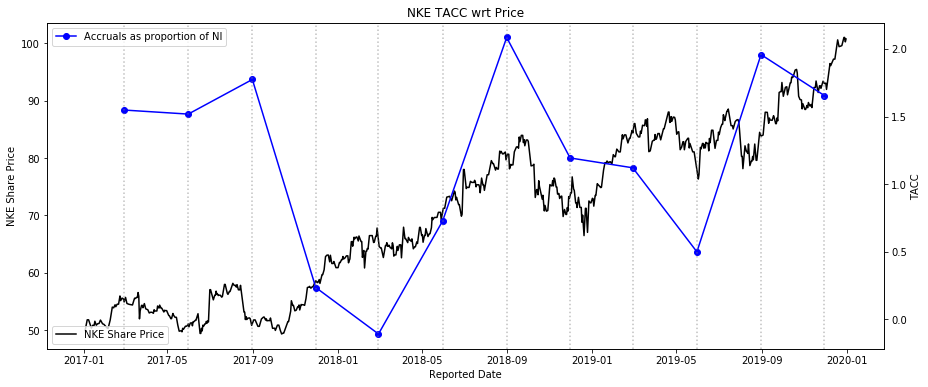

In [88]:
plot_accruals('NKE',working_df,start_date,end_date)

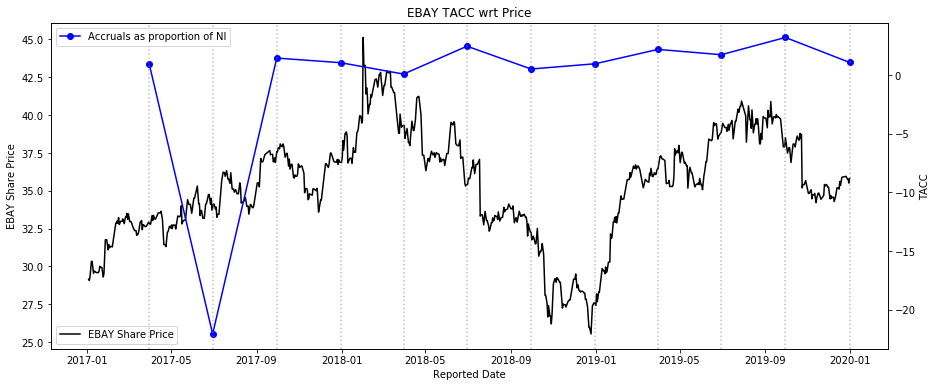

In [89]:
plot_accruals('EBAY',working_df,start_date,end_date)

## Part 3 - Generating Positions for the timeperiod
1. Stitch together accruals & estimates, sort accordingly and get the tickers 

For reference:
- working_df - fundamentals data
- e_hist_final - estimates data

Text(0, 0.5, 'Count of Announcements')

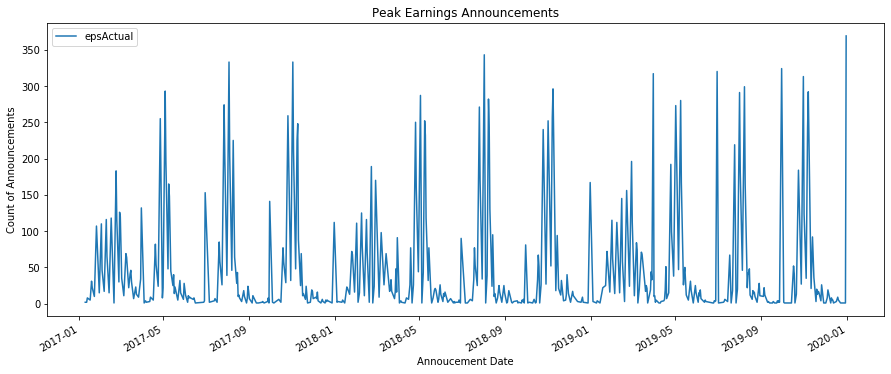

In [63]:
# To visualise which dates have the bulk of earnings announcements
freq_table = e_hist_final.groupby('reportDate').count()[['epsActual']]
freq_table.plot(figsize=(15,6))
plt.title('Peak Earnings Announcements')
plt.xlabel('Annoucement Date')
plt.ylabel('Count of Announcements')

Ideally we would want to perform rebalancing as frequently as possible to best optimize. However, for practicality sake for now i've excluded that and taken on an approach where i rebalance at the end of each month.

In [64]:
# Creating columns with month & year for ease of creating positions later on
working_df['month'] = working_df['date'].dt.month
working_df['year'] = working_df['date'].dt.year
e_hist_final['month'] = e_hist_final['reportDate'].dt.month
e_hist_final['year'] = e_hist_final['reportDate'].dt.year

In [65]:
rebalancing_dates = pd.date_range(start_date,end_date,freq='M')

In generating positions, we prioritise PEAD and refine it further with accrual anomality.

Essentially, what I am aiming to filter out are stocks that surprise positively (negatively) on earnings and persist with low (high) accruals.

In [66]:
%%time
positions_dict = {}
all_tickers = []
for i in range(len(rebalancing_dates)-1):
    d = rebalancing_dates[i]
    date = str(d.date())
    month = d.month
    year = d.year
    
    #This identifies tickers available for that datetime based on estimates
    estimates_list = e_hist_final[(e_hist_final['month'] == month) & (e_hist_final['year'] == year)]
    tickers = estimates_list['Ticker']
    
    #Selecting the top 10% to long/short
    n = int(round(0.1 * len(estimates_list),0))
    
    #This pulls the latest accrual figure for the relevant tickers
    accruals = working_df[(working_df['Ticker'].isin(tickers)) & (working_df['date'] <= d) ]
    accruals = accruals[['Ticker','date','ACC_Income']]
    accruals.sort_values(by=['ACC_Income'],inplace=True,ascending=True)
    accruals.drop_duplicates(subset=['Ticker'],inplace=True,keep='last')
    
    #merging and sorting based on PEAD and Accruals
    main = pd.merge(estimates_list,accruals,how='left',on='Ticker')
    long = main.sort_values(by=['surprisePercent','ACC_Income'],ascending=[False,True])
    short = main.sort_values(by=['surprisePercent','ACC_Income'],ascending=[False,False])
    
    #collecting the ticker to purhcase
    long = long[long['epsDifference'] > 0].head(n)['Ticker'].to_list()
    short = short[short['epsDifference'] < 0].head(n)['Ticker'].to_list()
    
    positions_dict[date] = {
                        'long':long,
                        'short':short
                        }
    #this compiles all the tickers of interest
    for t in long:
        if t not in all_tickers:
            all_tickers.append(t)
    for s in short:
        if s not in all_tickers:
            all_tickers.append(s)

CPU times: user 958 ms, sys: 19.9 ms, total: 977 ms
Wall time: 988 ms


## Part 4 - Backtesting

1. To optimize speed, prepare a price_dictionary with Key: Ticker , Value: DataFrame with price data

In [67]:
def get_returns(ticker,start_date,end_date,pos_type,price_df):
    '''
    Function to calculate returns
    '''
    try:
        p_1 = price_df[(price_df['Date']==start_date)]['Adjusted_close'].values[0]
        p_2 = price_df[(price_df['Date']==end_date)]['Adjusted_close'].values[0]
    except:
        #if for some reason the price data does not exist, return false and continue to next ticker
        return False
    if pos_type == 'long':
        returns = (p_2/p_1) - 1
    else:
        returns = -(p_2/p_1) + 1
    return returns

In [68]:
p_df = pd.read_csv('US_price.csv')

In [69]:
price = p_df[['Ticker','Adjusted_close','Date']]
price[['Date']] = price[['Date']].apply(pd.to_datetime)
price = price[(price['Date']>=start_date) & (price['Date']<=end_date) & (price['Ticker'].isin(all_tickers))]

In [70]:
%%time
price_dict = {}
for t in all_tickers:
    temp = price[price['Ticker']==t]
    temp.set_index('Date',inplace=True)
    
    #resampling index to contain all dates in the event the dates don't sync up
    idx = pd.date_range(start_date,end_date)
    temp = temp.reindex(idx, method='ffill')
    temp.reset_index(inplace=True)
    temp.columns = ['Date','Ticker','Adjusted_close']
    temp.dropna(inplace=True)
    
    temp = temp[temp['Date'].isin(rebalancing_dates)]
    price_dict[t] = temp

CPU times: user 6min 56s, sys: 4.6 s, total: 7min
Wall time: 8min 16s


In [71]:
price_dict['EBAY'].head()

,Date,Ticker,Adjusted_close
30,2017-01-31,EBAY,31.1003
58,2017-02-28,EBAY,33.1228
89,2017-03-31,EBAY,32.8003
119,2017-04-30,EBAY,32.6441
150,2017-05-31,EBAY,33.5136


## Backtesting

In [72]:
%%time
backtest_result = 0.0
long_result = 0.0
short_result = 0.0
long_dict = {}
short_dict = {}
total_dict = {}
for i in range(0,len(rebalancing_dates)-1):
    
    d = str(rebalancing_dates[i].date())
    long = positions_dict[d]['long']
    short = positions_dict[d]['short']
    end_date = rebalancing_dates[i+1]
    total_positions = len(long) + len(short)
    
    long_returns = 0
    short_returns = 0
    long_count = 0
    short_count = 0
    for stock in long:
        ret = get_returns(stock,d,end_date,'long',price_dict[stock])
        
        #if for some reason the price data does not exist, return false and continue to next ticker
        if ret == False:
            continue
        long_returns += ret
        long_count += 1

    
    for stock in short:
        ret = get_returns(stock,d,end_date,'short',price_dict[stock])
        
        #if for some reason the price data does not exist, return false and continue to next ticker
        if ret == False:
            continue
        short_returns += ret
        short_count += 1
    
    #containing the data
    long_dict[i] = [d,long_returns/len(long)]
    short_dict[i] = [d,short_returns/len(short)]
    
    backtest_result += (long_returns + short_returns)/total_positions
    long_result += long_returns/long_count
    short_result += short_returns/short_count
    
    total_dict[i] = [d,(long_returns + short_returns)/total_positions]
print("Backtest completed.")
print("Total Performance:{}%".format(round(backtest_result*100,5)))
print("Long Performance:{}%".format(round(long_result*100,5)))
print("Short Performance:{}%".format(round(short_result*100,5)))
print("-------")

Backtest completed.
Total Performance:16.83023%
Long Performance:37.50103%
Short Performance:-2.07718%
-------
CPU times: user 10.2 s, sys: 95.7 ms, total: 10.3 s
Wall time: 10.4 s


# Part 5 - Plot performance and benchmark against SPY

We benchmark against SPY.

In [73]:
#SPY Data for cumsum
df = pd.DataFrame()
df['SPY'] = wb.DataReader('SPY',data_source='yahoo',start=start_date,end=end_date)['Adj Close']
idx = pd.date_range(start_date,end_date)
df = df.reindex(idx, method='ffill')
df.reset_index(inplace=True)
df.columns = ['Date','SPY']
df.dropna(inplace=True)
spy_cumsum = df.copy()
spy_cumsum['Returns'] = (spy_cumsum['SPY']/spy_cumsum['SPY'].shift(1) - 1)
spy_cumsum.dropna(inplace=True)

In [74]:
spy_cumsum.head()

,Date,SPY,Returns
3,2017-01-04,212.811111,0.005949
4,2017-01-05,212.642044,-0.000794
5,2017-01-06,213.402817,0.003578
6,2017-01-07,213.402817,0.000000
7,2017-01-08,213.402817,0.000000


In [75]:
total = pd.DataFrame.from_dict(total_dict,orient='index',columns=['Date','Returns'])
total[['Date']] = total[['Date']].apply(pd.to_datetime)

long = pd.DataFrame.from_dict(long_dict,orient='index',columns=['Date','Returns'])
long[['Date']] = long[['Date']].apply(pd.to_datetime)

short = pd.DataFrame.from_dict(short_dict,orient='index',columns=['Date','Returns'])
short[['Date']] = short[['Date']].apply(pd.to_datetime)

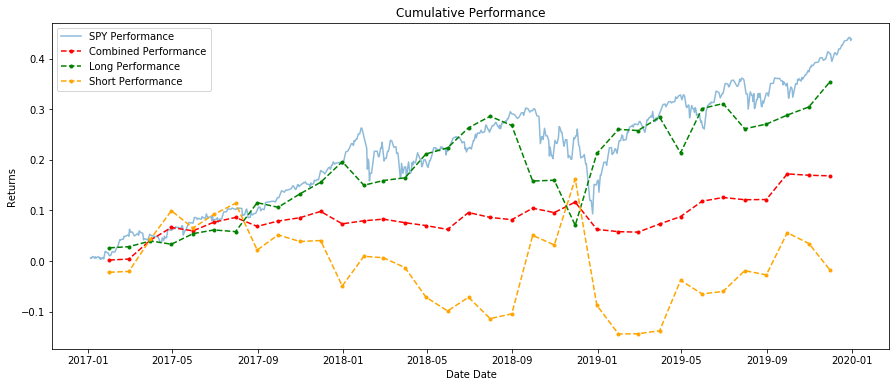

In [76]:
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(spy_cumsum['Date'],spy_cumsum['Returns'].cumsum(),label='SPY Performance',alpha=0.5)
ax1.plot(total['Date'],total['Returns'].cumsum(),label='Combined Performance',linestyle='--',color='red',marker='.')
ax1.plot(long['Date'],long['Returns'].cumsum(),label='Long Performance',linestyle='--',color='green',marker='.')
ax1.plot(short['Date'],short['Returns'].cumsum(),label='Short Performance',linestyle='--',color='orange',marker='.')
ax1.set_xlabel('Date Date')
ax1.set_ylabel('Returns',color='black')

plt.title('Cumulative Performance',color='black')
ax1.legend(loc='upper left')
plt.show()

In [77]:
#SPY Data for monthly non-cumulative returns
s = wb.DataReader('SPY',data_source='yahoo',start=start_date,end=end_date)['Adj Close']
spy_monthly = pd.DataFrame(s.asfreq('M', method='ffill'))
spy_monthly.reset_index(inplace=True)
spy_monthly.columns = ['Date','SPY']
spy_monthly['Returns'] = (spy_monthly['SPY']/spy_monthly['SPY'].shift(1) - 1)
df.dropna(inplace=True)

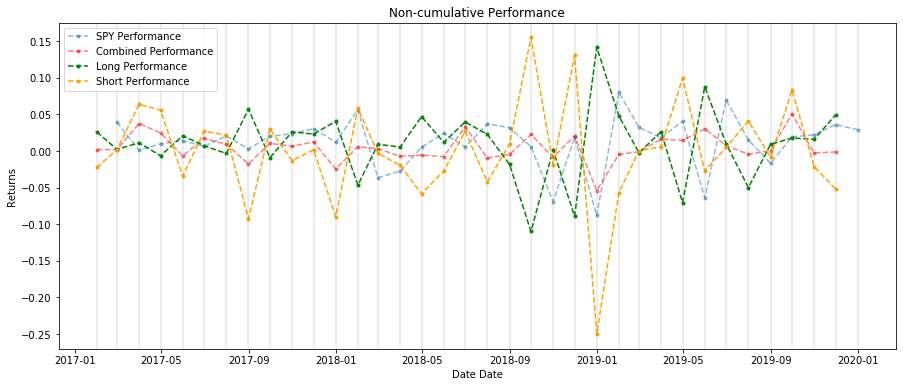

In [78]:
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(spy_monthly['Date'],spy_monthly['Returns'],label='SPY Performance',linestyle='--',marker='.',alpha=0.5)
ax1.plot(total['Date'],total['Returns'],label='Combined Performance',linestyle='--',color='red',marker='.',alpha=0.5)
ax1.plot(long['Date'],long['Returns'],label='Long Performance',linestyle='--',color='green',marker='.')
ax1.plot(short['Date'],short['Returns'],label='Short Performance',linestyle='--',color='orange',marker='.')
ax1.set_xlabel('Date Date')
ax1.set_ylabel('Returns',color='black')
for point in spy_monthly['Date']:
        plt.axvline(x=point,color='grey',alpha=0.2,linestyle='-')
plt.title('Non-cumulative Performance',color='black')
ax1.legend(loc='upper left')
plt.show()

### Conclusions & potential follow up

Observations
1. The top 10% and bottom 10% of the appear to be inversely related between 2018-06 to 2019-01.
2. Shorting really doesn't seem to go well.
3. PEAD + Accruals underperforms, for when we factor in transaction costs, even if we only go long, the returns will be significant less than SPY. 
4. The strategy is missing key growth stocks that have contributed to SPY's performance and thus when we include them, the results could change drastically. (Refer to Appendix A)


Follow up
1. One could look at the data between 2018-06 to 2019-01 and understand what led to the inverse relation.
2. Could also further refine this to target small cap stocks and verify the other anomalies presented in the book mentioned earlier
3. Instead of soley using Earnings Estimates, could also attempt the same strategy with estimates on Revenue/Expenditure etc

### Appendix A
Notable high performing tickers missing from the strategy above due to data unavailability by taking the difference between SPY and the tickers included. E.g GOOGL, FB, AAPL, MSFT

In [79]:
import bs4 as bs
import requests

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
spy_tickers = []
for row in table.findAll('tr')[1:]:
    spy_ticker = row.findAll('td')[0].text
    spy_tickers.append(spy_ticker.strip())

In [80]:
print('Full list of unavailable tickers')
print('-----')
print(sorted(list(set(spy_tickers)-set(tickers))))

Full list of unavailable tickers
-----
['AAL', 'AAPL', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADM', 'ADP', 'ADS', 'AEP', 'AFL', 'AJG', 'AKAM', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BK', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTVA', 'CTXS', 'CXO', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DOW', 'DPZ', 'DRE', 'DRI', 'DTE', 'EA', 'EBAY', 'ECL', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EQIX', 'EQR', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXR', 'F', 'F